# Ames Housing Prices Predictions

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad.  
But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this [competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) challenges you to predict the final price of each home.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Data

In [2]:
train = pd.read_csv('data/houseprices/train.csv')
test = pd.read_csv('data/houseprices/test.csv')

In [3]:
def format_train_test_data(train, test):
    
    # replace Alley NA with None
    train.Alley.fillna('None', inplace=True)
    test.Alley.fillna('None', inplace=True)

    # replace MasVnrArea na with 0
    train.MasVnrArea.fillna(0, inplace=True)
    test.MasVnrArea.fillna(0, inplace=True)

    # replace NAs from not having a basement, freplace, garage, pool, miscellaneous feature
    # fence with None
    na_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageType', \
               'BsmtFinType1', 'BsmtFinType2', 'GarageYrBlt', 'GarageFinish', \
               'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

    for col in na_columns:
        train[col].fillna('None', inplace=True)
        test[col].fillna('None', inplace=True)

    # replace continous  feature NAs 
    # fill these with zero
    fill_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
                 'BsmtHalfBath', 'GarageCars', 'GarageArea']
    for col in fill_zero:
        train[col].fillna(0, inplace=True)
        test[col].fillna(0, inplace=True)

    
    # replace LotFrontage NA with mean
    train.LotFrontage.fillna(train.LotFrontage.mean(), inplace=True)
    test.LotFrontage.fillna(test.LotFrontage.mean(), inplace=True)

    # apply log to skewed columns
    numeric_columns = train._get_numeric_data().columns
    skewed = []
    for col in numeric_columns:
        if (train[col].skew() < -2) or (train[col].skew() > 2):
            skewed.append(col)
    for col in skewed:
        train[col] = train[col] + 1
        test[col] = test[col] + 1
        train[col] = np.log10(train[col])
        test[col] = np.log10(test[col])
    
    # apply log10 transformation to Sale Price
    train.SalePrice = np.log10(train.SalePrice)
    
     # concatenate dataframes
    houses = pd.concat([train.drop('SalePrice', axis=1), test]).reset_index(drop=True)
    # get dummy variables
    houses_dummy = pd.get_dummies(houses)
    # sort by Id to slice out test data accurately
    houses_dummy.sort_values(by='Id', inplace=True)
    # split train and test data
    train_dummy = houses_dummy.ix[:1459, :].copy()
    test_dummy = houses_dummy.ix[1460:, :].copy()
    # add Sale Price column back to train dataframe
    train_dummy['SalePrice'] = train.SalePrice
    
    return train_dummy, test_dummy


In [4]:
train_dummy, test_dummy = format_train_test_data(train, test)

In [5]:
train.tail(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1458,1459,20,RL,1.838849,3.987577,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,4,2010,WD,Normal,5.152670
1459,1460,20,RL,1.880814,3.997299,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,6,2008,WD,Normal,5.168792


In [6]:
train_dummy.tail(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1458,1459,20,1.838849,3.987577,5,6,1950,1996,0.0,49.0,...,0,0,1,0,0,0,0,1,0,5.152670
1459,1460,20,1.880814,3.997299,5,6,1965,1965,0.0,830.0,...,0,0,1,0,0,0,0,1,0,5.168792


In [7]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,1.908485,4.065318,Pave,None,Reg,Lvl,AllPub,...,2.082785,0.0,None,MnPrv,None,0.000000,6,2010,WD,Normal
1,1462,20,RL,1.913814,4.154363,Pave,None,IR1,Lvl,AllPub,...,0.000000,0.0,None,None,Gar2,4.096945,6,2010,WD,Normal


In [8]:
test_dummy.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,1461,20,1.908485,4.065318,5,6,1961,1961,0.000000,468.0,...,0,0,0,1,0,0,0,0,1,0
1461,1462,20,1.913814,4.154363,6,6,1958,1958,2.037426,923.0,...,0,0,0,1,0,0,0,0,1,0


In [9]:
train_dummy.shape

(1460, 407)

In [10]:
test_dummy.shape

(1459, 406)

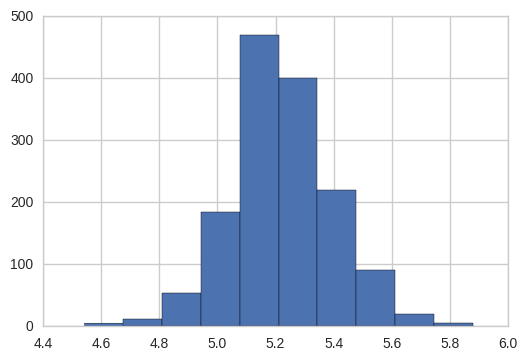

In [11]:
train_dummy.SalePrice.hist()

# Train test split

In [12]:
from sklearn.model_selection import train_test_split

X = train_dummy.iloc[:, train_dummy.columns != 'SalePrice']
y = train_dummy.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Accuracy measure
log of MSE

In [13]:
def mylog_rmse(y_true, y_pred):
    """
    Return log root mean square error
    Assumes y is already in log scale
    Input: tuple of True values of y, Predicted values of y
    Output: log rmse
    """
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# check for outliers

In [14]:
def skewed_columns(train):
    numeric_columns = train._get_numeric_data().columns
    skewed_columns = []
    for column in numeric_columns:
        if column in X_train.columns:
            if (X_train[column].skew() < -2) or (X_train[column].skew() > 2):
                skewed_columns.append(column)
    return skewed_columns

In [15]:
skewed_columns(train)

['BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

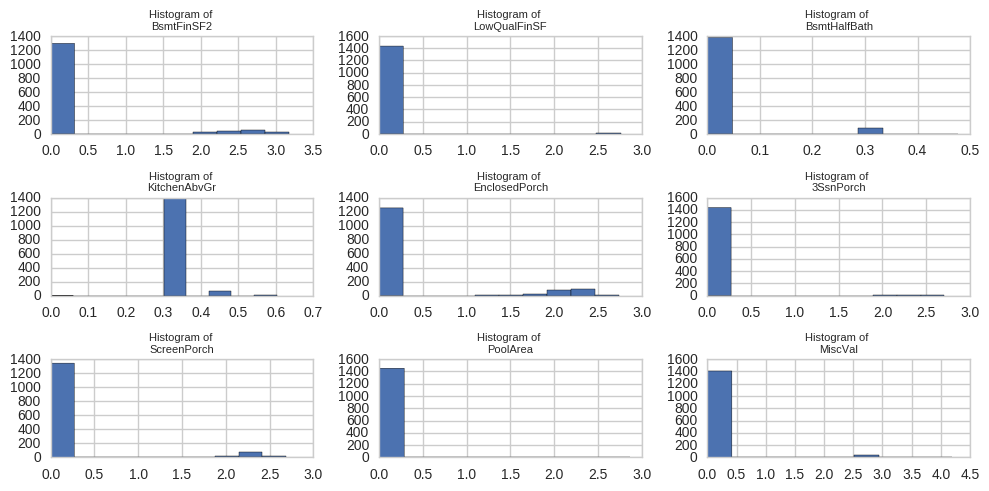

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,5))

for column, ax in zip(skewed_columns(train), axes.ravel()):
    ax.hist(train_dummy[column])
    ax.set_title('Histogram of \n{}'.format(column), fontsize=8)
fig.tight_layout()
plt.show()

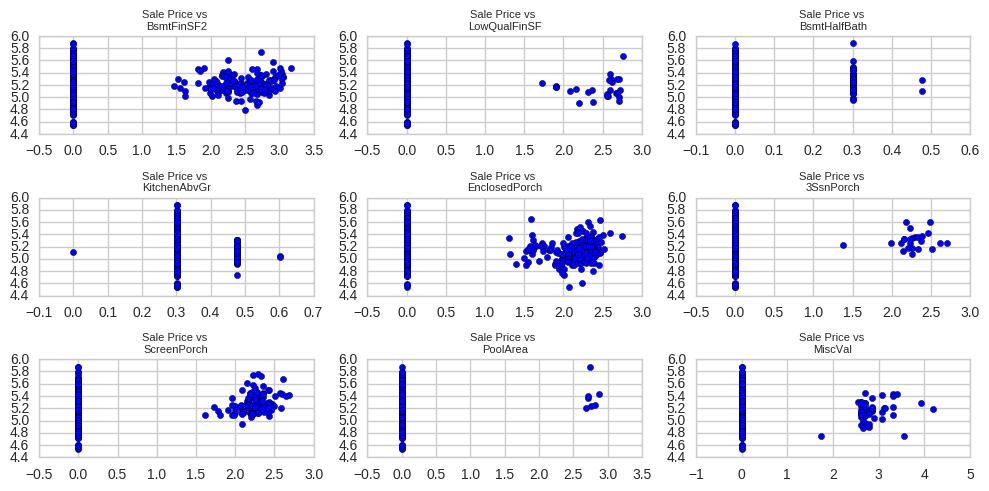

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,5))

for column, ax in zip(skewed_columns(train), axes.ravel()):
    ax.scatter(train_dummy[column], train_dummy.SalePrice)
    ax.set_title('Sale Price vs \n{}'.format(column), fontsize=8)
fig.tight_layout()
plt.show()

Most of the extreme values seem to appear in variables that most houses do not possess hence many zeroes and scattered extreme values

# Outliers pointed out by proveider of dataset

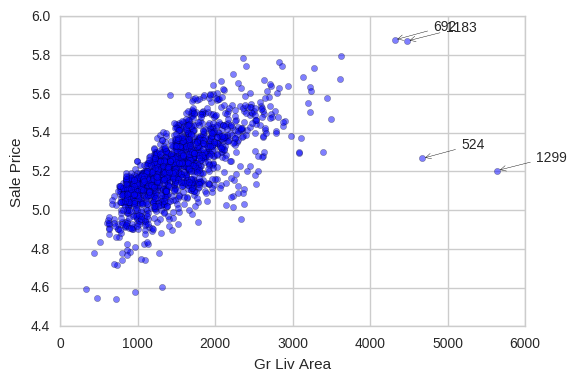

In [18]:
fig, ax = plt.subplots()

ax.scatter(train_dummy.GrLivArea, train_dummy.SalePrice, alpha=0.5)
ax.set(xlabel='Gr Liv Area', ylabel='Sale Price')

for point_id, x, y in zip(train_dummy.Id, train_dummy.GrLivArea, train_dummy.SalePrice):
    if x > 4000:
        # outliers -> GrLivArea above 4000
        ax.annotate(point_id, xy=(x, y), xytext=(x+500, y+0.05), arrowprops=dict(arrowstyle = '->'))


plt.show()

In [19]:
# removing these points
train_dummy = train_dummy.ix[train_dummy.GrLivArea < 4000, :].copy()
train_dummy.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,1.819544,3.926908,7,5,2003,2003,2.294466,706.0,...,0,0,1,0,0,0,0,1,0,5.319106
1,2,20,1.908485,3.982316,6,8,1976,1976,0.000000,978.0,...,0,0,1,0,0,0,0,1,0,5.258877
2,3,60,1.838849,4.051191,7,5,2001,2002,2.212188,486.0,...,0,0,1,0,0,0,0,1,0,5.349278
3,4,70,1.785330,3.980049,7,5,1915,1970,0.000000,216.0,...,0,0,1,1,0,0,0,0,0,5.146128
4,5,60,1.929419,4.154150,8,5,2000,2000,2.545307,655.0,...,0,0,1,0,0,0,0,1,0,5.397940


# Ridge Regression

In [20]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Ridge with standardized X

In [21]:
def do_grid_search(estimator, param_grid):
    
    grid_search = GridSearchCV(estimator, 
                               param_grid, 
                               n_jobs=-1, 
                               cv=5, 
                               scoring='neg_mean_squared_error')
    %time grid_search.fit(X_train, y_train)

    print("Test set log adj RMSE: {:.5f}".format(mylog_rmse(y_test, grid_search.predict(X_test))))
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    results = pd.DataFrame(grid_search.cv_results_)
    
    return grid_search, results

In [20]:
param_grid={'ridge__alpha': [0.1, 1, 10] + list(range(20,200,20)) + [1000]
           }
grid_search, results = do_grid_search(estimator = make_pipeline(StandardScaler(), Ridge(random_state=0)), 
                                      param_grid = param_grid)

CPU times: user 348 ms, sys: 48 ms, total: 396 ms
Wall time: 4.54 s
Test set log adj RMSE: 0.08463
Best parameters: {'ridge__alpha': 180}
Best cross-validation score: -0.00


In [21]:
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.139610,0.007652,-0.004516,-0.001019,0.1,{'ridge__alpha': 0.1},13,-0.004889,-0.000985,-0.007168,...,-0.003583,-0.000986,-0.004322,-0.001102,-0.002620,-0.001060,0.027308,0.003803,0.001528,0.000053
1,0.086797,0.004487,-0.004197,-0.001022,1,{'ridge__alpha': 1},12,-0.003955,-0.000987,-0.007123,...,-0.003599,-0.000987,-0.003752,-0.001104,-0.002554,-0.001066,0.003398,0.000999,0.001541,0.000053
2,0.088937,0.004746,-0.003983,-0.001041,10,{'ridge__alpha': 10},11,-0.003734,-0.001011,-0.006707,...,-0.003554,-0.001001,-0.003461,-0.001126,-0.002459,-0.001092,0.002393,0.001391,0.001432,0.000057
3,0.092865,0.006873,-0.003851,-0.001062,20,{'ridge__alpha': 20},10,-0.003609,-0.001034,-0.006394,...,-0.003523,-0.001018,-0.003314,-0.001147,-0.002414,-0.001116,0.004227,0.003682,0.001341,0.000059
4,0.092895,0.007064,-0.003674,-0.001097,40,{'ridge__alpha': 40},9,-0.003411,-0.001071,-0.006006,...,-0.003483,-0.001048,-0.003117,-0.001183,-0.002355,-0.001155,0.006415,0.002012,0.001232,0.000061


In [22]:
def plot_CV_one_param(results_df, param_column, ax=None):
    
    if ax == None:
        ax = plt.gca()
     
    parameter_values = results_df[param_column].astype(np.float64)
    
    train_scores_mean = results_df['mean_train_score']
    train_scores_std = results_df['std_train_score']
    
    validation_scores_mean = results_df['mean_test_score']
    validation_scores_std = results_df['std_test_score']
    
    ax.fill_between(parameter_values, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    ax.plot(parameter_values, train_scores_mean, marker='o', ls='-', color='r', label='train')
    
    ax.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                    validation_scores_mean + validation_scores_std, alpha=0.1, color='blue')
    ax.plot(parameter_values, validation_scores_mean, marker='o', ls='-', color='green', label='validation')
    
    ax.set_title('CV curve for {}'.format(param_column))
    ax.set_xlabel(param_column)
    ax.set_ylabel('negative MSE')
    ax.legend(loc='best')
        
    return ax

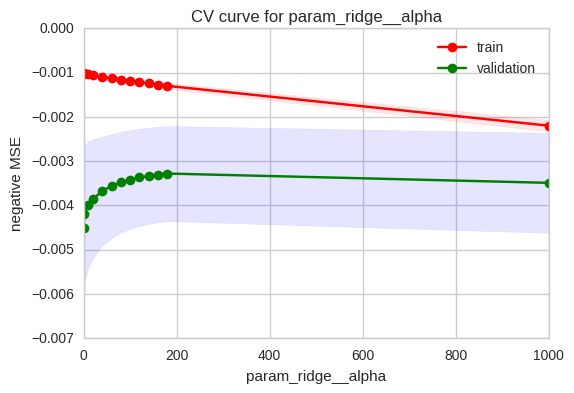

In [23]:
plot_CV_one_param(results, 'param_ridge__alpha')

High regularization of alpha $\approx$ 200

# With PCA

In [23]:
from sklearn.decomposition import PCA

In [24]:
number_of_components = range(2, 70)
explained_var = []

for n in number_of_components:
    pca = PCA(n_components=n)
    pca.fit_transform(train_dummy)
    explained_var.append(sum(pca.explained_variance_ratio_))

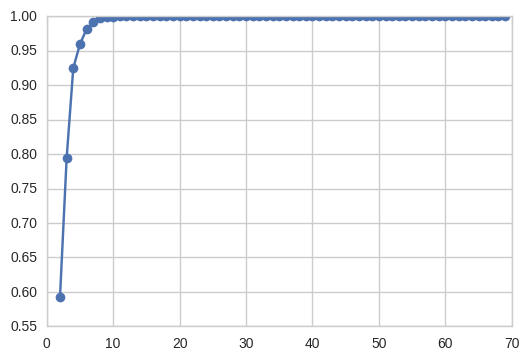

In [25]:
fig, ax = plt.subplots()

ax.plot(number_of_components, explained_var, marker='o')

plt.show()

About 10 components explain most of the variance on this dataset

## Ridge alpha=1 with PCA

In [24]:
param_grid={ 'pca__n_components': list(range(10,90,10)) + list(range(100,400,50))
           }
grid_search, results = do_grid_search(estimator = make_pipeline(StandardScaler(), PCA(), Ridge(random_state=0)), 
                                      param_grid = param_grid)

CPU times: user 1.03 s, sys: 192 ms, total: 1.22 s
Wall time: 23.2 s
Test set log adj RMSE: 0.08292
Best parameters: {'pca__n_components': 200}
Best cross-validation score: -0.00


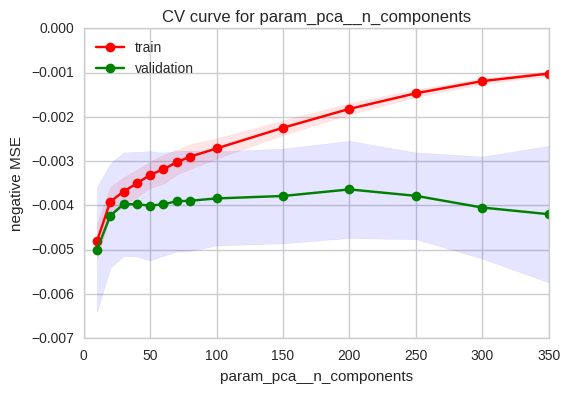

In [25]:
plot_CV_one_param(results, 'param_pca__n_components')

# Ridge alpha=200 PCA

In [26]:
param_grid={ 'pca__n_components': list(range(10,90,10)) + list(range(100,400,50))
           }
grid_search, results = do_grid_search(estimator = make_pipeline(StandardScaler(), PCA(), Ridge(random_state=0, alpha=200)), 
                                      param_grid = param_grid)

CPU times: user 756 ms, sys: 48 ms, total: 804 ms
Wall time: 20.7 s
Test set log adj RMSE: 0.08390
Best parameters: {'pca__n_components': 350}
Best cross-validation score: -0.00


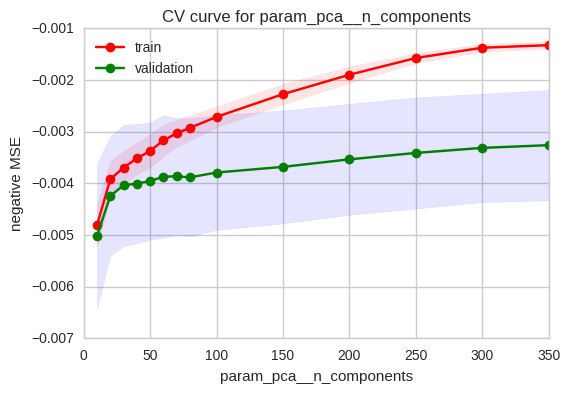

In [27]:
plot_CV_one_param(results, 'param_pca__n_components')

Low regularization gets minimum validation error when number of principal components is reduced to 200.
High regularization gets minimum validation error when number of principal components $\approx$ number of features in dataset.

In [26]:
def plot_meanCV_two_params(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None, vmin=None, vmax=None, ax=None, fmt="%0.4f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

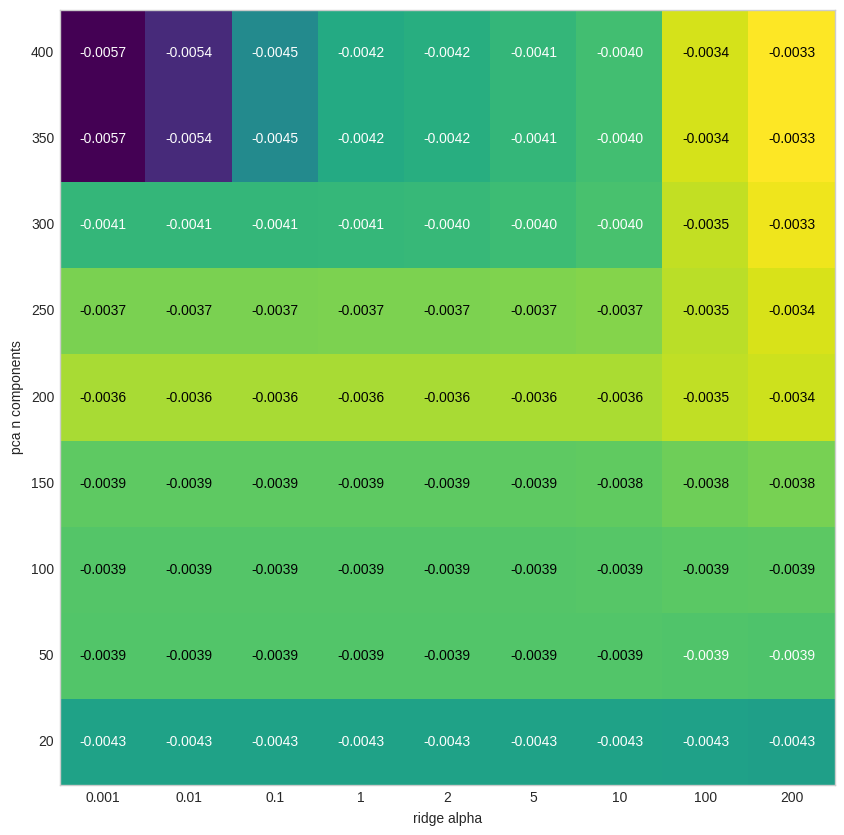

In [23]:
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(9, 9)

fig, ax = plt.subplots(figsize=(10,10))

plot_meanCV_two_params(scores, xlabel='ridge alpha', xticklabels=param_grid['ridge__alpha'], ylabel='pca n components', 
        yticklabels=param_grid['pca__n_components'], cmap='viridis', ax=ax)

Using all features with high regularization gets lower validation error than PCA with few principal components and little regularization

# The Lasso with standardized X

In [32]:
param_grid={ 'lasso__alpha': [0.001, 0.01, 0.1, 1, 2]
           }
grid_search, results = do_grid_search(estimator = make_pipeline(StandardScaler(), Lasso(random_state=0)), 
                                      param_grid = param_grid)

CPU times: user 224 ms, sys: 20 ms, total: 244 ms
Wall time: 1.67 s
Test set log adj RMSE: 0.08888
Best parameters: {'lasso__alpha': 0.001}
Best cross-validation score: -0.00


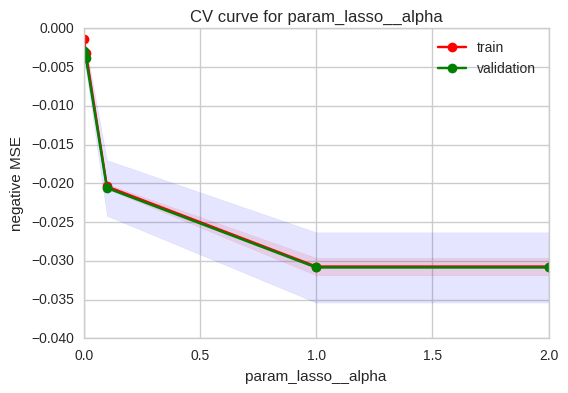

In [33]:
plot_CV_one_param(results, 'param_lasso__alpha')

Apparently, validation error is lowest when solution $\approx$ least squares solution

# Lasso alpha=1 with PCA

In [36]:
param_grid={  'pca__n_components': [20, 50, 100, 150, 200, 250, 300, 350, 400]
           }
grid_search, results = do_grid_search(estimator = make_pipeline(StandardScaler(), PCA(), Lasso(random_state=0, alpha=0.001)), 
                                      param_grid = param_grid)

CPU times: user 704 ms, sys: 16 ms, total: 720 ms
Wall time: 18.3 s
Test set log adj RMSE: 0.08179
Best parameters: {'pca__n_components': 350}
Best cross-validation score: -0.00


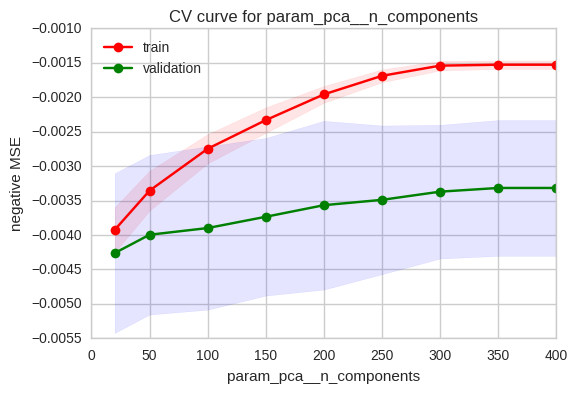

In [37]:
plot_CV_one_param(results, 'param_pca__n_components')

PCA is not useful in this case, all features are needed to get lowest validation error

# Elastic Net

In [39]:
param_grid = {'elasticnet__alpha': [0.01, 0.01, 0.1, 0.5, 0.7], 
              'elasticnet__l1_ratio': [0.01, 0.01, 0.1, 0.5, 0.7]} 
grid_search, results = do_grid_search(estimator =make_pipeline(StandardScaler(), ElasticNet(random_state=0)), 
                                      param_grid = param_grid)

CPU times: user 560 ms, sys: 60 ms, total: 620 ms
Wall time: 8.71 s
Test set log adj RMSE: 0.08169
Best parameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.01}
Best cross-validation score: -0.00


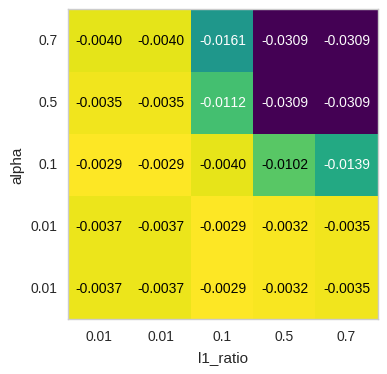

In [40]:
scores = np.array(results.mean_test_score).reshape(5, 5)
# plot the mean cross-validation scores

plot_meanCV_two_params(scores, xlabel='l1_ratio', xticklabels=param_grid['elasticnet__l1_ratio'], ylabel='alpha', 
        yticklabels=param_grid['elasticnet__alpha'], cmap='viridis')


# Elastic net alpha=0.1 l1_ratio=0.01 with PCA

In [43]:
param_grid = {'pca__n_components': [20, 50, 100, 150, 200, 250, 300, 350, 400]
             } 
grid_search, results = do_grid_search(estimator =make_pipeline(StandardScaler(), PCA(), ElasticNet(random_state=0, alpha=0.1, l1_ratio=0.01)), 
                                      param_grid = param_grid)

CPU times: user 656 ms, sys: 24 ms, total: 680 ms
Wall time: 17.9 s
Test set log adj RMSE: 0.07891
Best parameters: {'pca__n_components': 350}
Best cross-validation score: -0.00


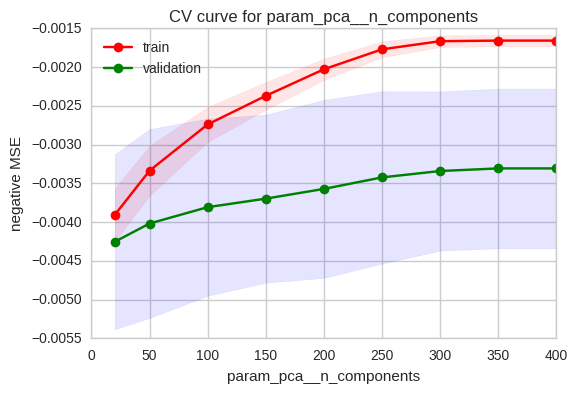

In [44]:
plot_CV_one_param(results, 'param_pca__n_components')

PCA not useful

# Kernel Methods

In [27]:
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler

# SVR 

In [61]:
param_grid={'svr__C': [0.1, 1, 5, 7, 10, 13], 
            'svr__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search, results = do_grid_search(estimator=make_pipeline(MinMaxScaler(), SVR()), 
               param_grid=param_grid)

CPU times: user 1.27 s, sys: 192 ms, total: 1.46 s
Wall time: 1min 1s
Test set log adj RMSE: 0.07412
Best parameters: {'svr__C': 7, 'svr__gamma': 0.001}
Best cross-validation score: -0.00


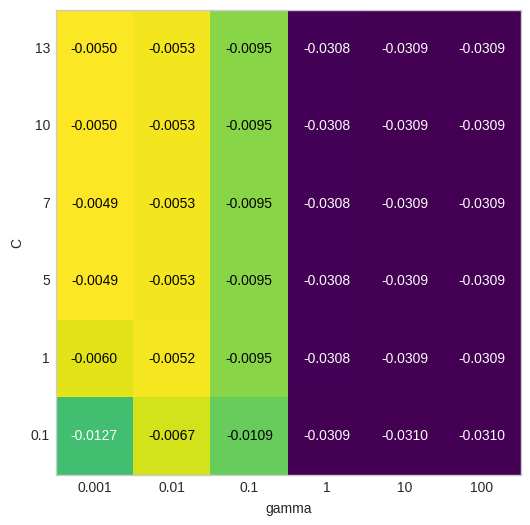

In [34]:
scores = np.array(results.mean_test_score).reshape(6,6)

fig, ax = plt.subplots(figsize=(6,6))

plot_meanCV_two_params(scores, xlabel='gamma', xticklabels=param_grid['svr__gamma'], ylabel='C', 
        yticklabels=param_grid['svr__C'], cmap='viridis', ax=ax)

## C

CPU times: user 748 ms, sys: 64 ms, total: 812 ms
Wall time: 18.2 s
Test set log adj RMSE: 0.16749
Best parameters: {'C': 0.01}
Best cross-validation score: -0.03


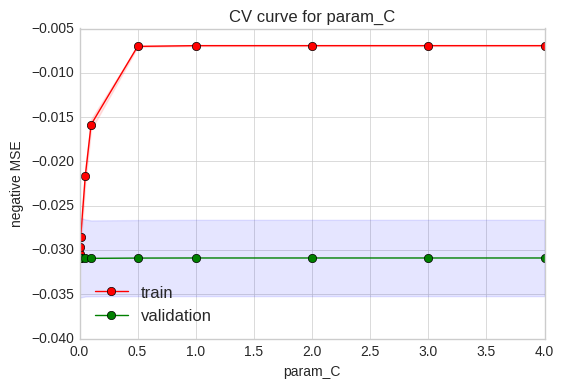

In [100]:
param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5] + list(range(1, 5))
           }
grid_search, results = do_grid_search(estimator = SVR(), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_C')

## Gamma

CPU times: user 784 ms, sys: 28 ms, total: 812 ms
Wall time: 14.7 s
Test set log adj RMSE: 0.16750
Best parameters: {'gamma': 0.001}
Best cross-validation score: -0.03


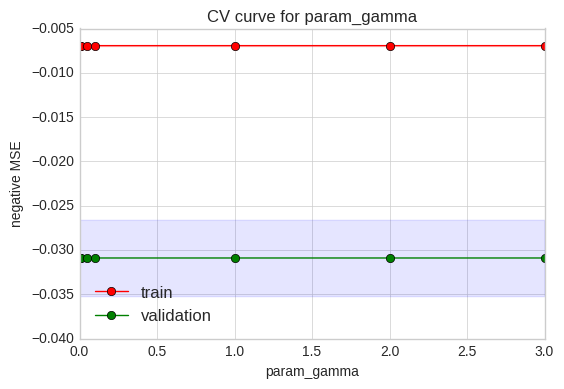

In [101]:
param_grid={'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2, 3]
           }
grid_search, results = do_grid_search(estimator = SVR(), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_gamma')

Validation error is almost constant with a given value of gamma and changing C. Low gamma of 0.001 and C of 7 gives minimum validation error

# Kernel Ridge

In [44]:
param_grid={'kernelridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1], 
            'kernelridge__gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 1]
           }
grid_search, results = do_grid_search(estimator = make_pipeline(MinMaxScaler(), KernelRidge(kernel='rbf')), 
                                      param_grid = param_grid)

CPU times: user 1.08 s, sys: 168 ms, total: 1.24 s
Wall time: 51.1 s
Test set log adj RMSE: 0.06206
Best parameters: {'kernelridge__alpha': 0.01, 'kernelridge__gamma': 0.005}
Best cross-validation score: -0.00


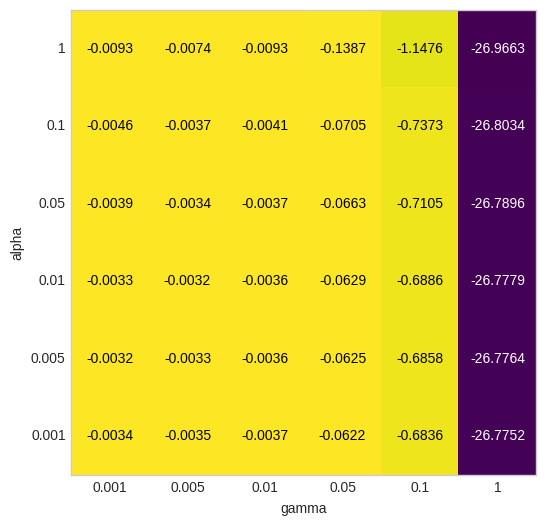

In [45]:
scores = np.array(results.mean_test_score).reshape(6,6)

fig, ax = plt.subplots(figsize=(6,6))

plot_meanCV_two_params(scores, xlabel='gamma', xticklabels=param_grid['kernelridge__gamma'], ylabel='alpha', 
        yticklabels=param_grid['kernelridge__alpha'], cmap='viridis', ax=ax)

## C

CPU times: user 428 ms, sys: 96 ms, total: 524 ms
Wall time: 8.03 s
Test set log adj RMSE: 0.07534
Best parameters: {'alpha': 10}
Best cross-validation score: -0.00


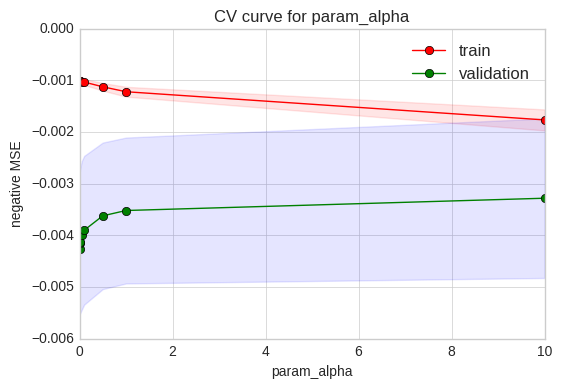

In [103]:
param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10]
           }
grid_search, results = do_grid_search(estimator = KernelRidge(gamma=0.01), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_alpha')

## gamma

CPU times: user 432 ms, sys: 84 ms, total: 516 ms
Wall time: 7.47 s
Test set log adj RMSE: 0.08463
Best parameters: {'gamma': 0.001}
Best cross-validation score: -0.00


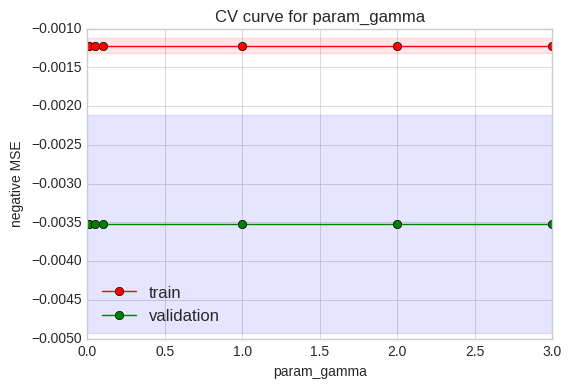

In [104]:
param_grid={'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2, 3]
           }
grid_search, results = do_grid_search(estimator = KernelRidge(), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_gamma')

Similar results to SVR

# Ensemble Models

# Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
param_grid={'max_depth': [2, 5, 10, 12, 15, 17, 20], 
            'max_features': [20, 50, 100, 150, 200, 250, 300]
           }
grid_search, results = do_grid_search(estimator = RandomForestRegressor(random_state=0, n_estimators=100), 
                                      param_grid = param_grid)

CPU times: user 2.38 s, sys: 140 ms, total: 2.52 s
Wall time: 2min 49s
Test set log adj RMSE: 0.05495
Best parameters: {'max_depth': 15, 'max_features': 100}
Best cross-validation score: -0.00


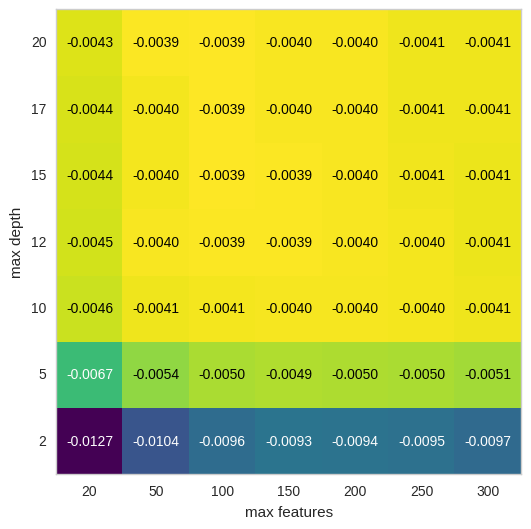

In [48]:
scores = np.array(results.mean_test_score).reshape(7,7)

fig, ax = plt.subplots(figsize=(6,6))

plot_meanCV_two_params(scores, xlabel='max features', xticklabels=param_grid['max_features'], ylabel='max depth', 
        yticklabels=param_grid['max_depth'], cmap='viridis', ax=ax)

## Max depth

In [49]:
param_grid={'max_depth': range(4, 15, 2)
           }
grid_search, results = do_grid_search(estimator = RandomForestRegressor(random_state=0, n_estimators=500), 
                                      param_grid = param_grid)

CPU times: user 16.9 s, sys: 56 ms, total: 17 s
Wall time: 3min 30s
Test set log adj RMSE: 0.05742
Best parameters: {'max_depth': 12}
Best cross-validation score: -0.00


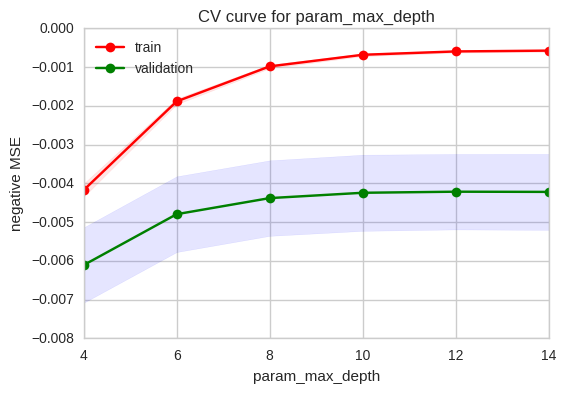

In [50]:
plot_CV_one_param(results, 'param_max_depth');

Optimal depth of trees should be between 10 and 14

# Max features

CPU times: user 2.4 s, sys: 44 ms, total: 2.44 s
Wall time: 54.8 s
Test set log adj RMSE: 0.05754
Best parameters: {'max_features': 180}
Best cross-validation score: -0.00


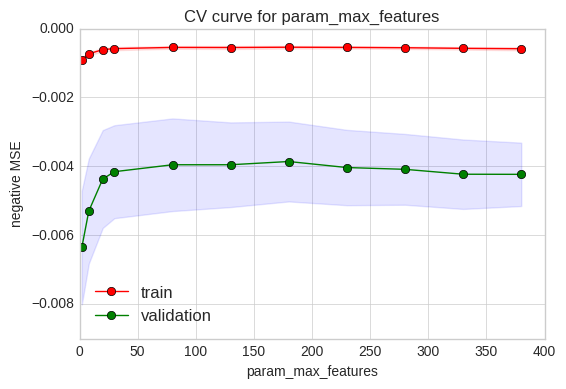

In [58]:
param_grid={'max_features': [2, 8, 20] + list(range(30, 400, 50))
           }
grid_search, results = do_grid_search(estimator = RandomForestRegressor(random_state=0, n_estimators=100), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_max_features')

Default of max features for regression is 400/3 $\approx$ 130. This seems a reasonable value according to the validation curve. 
Test error starts to plateau at >=80 features, but this has proved to restrictive a value to use according to my kaggle results with max features=80

# RF max depth=12 est=200 max features=auto with PCA

CPU times: user 3.76 s, sys: 224 ms, total: 3.98 s
Wall time: 5min 41s
Test set log adj RMSE: 0.07057
Best parameters: {'pca__n_components': 20}
Best cross-validation score: -0.00


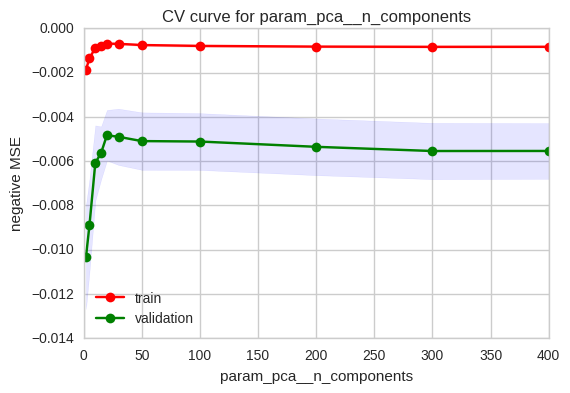

In [52]:
param_grid={'pca__n_components': [2, 5, 10, 15, 20, 30, 50, 100, 200, 300, 400]
           }
grid_search, results = do_grid_search(estimator = make_pipeline(PCA(), RandomForestRegressor(random_state=0, n_estimators=200, max_depth=12)), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_pca__n_components')

PCA with about 20 principal components gives lowest validation error. Remember about 99% of variation in dataset is explained by less than 20 components. Therefore each tree has access to almost all the variation in dataset, which reduces randomness of trees.
Using PCA with RF has brought poor results on Kaggle

# Gradient Boosting

In [29]:
from xgboost import XGBRegressor

## Max depth and learning rate

In [61]:
param_grid={'max_depth': [2, 8, 20, 100, 200, 350], 
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 1]
           }
grid_search, results = do_grid_search(estimator = XGBRegressor(seed=0, n_estimators=100), 
                                      param_grid = param_grid)

CPU times: user 3.76 s, sys: 100 ms, total: 3.86 s
Wall time: 4min 5s
Test set log adj RMSE: 0.05600
Best parameters: {'learning_rate': 0.1, 'max_depth': 8}
Best cross-validation score: -0.00


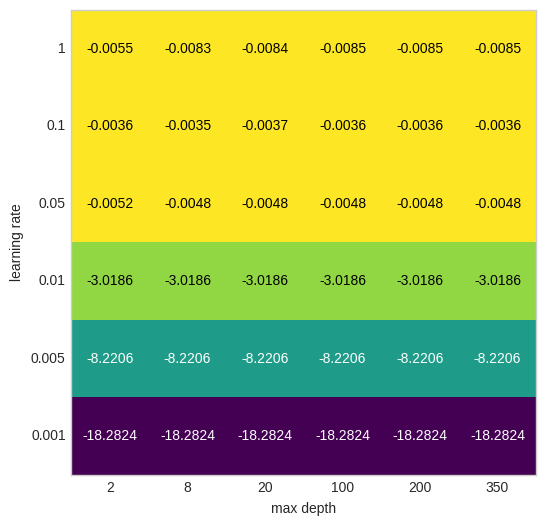

In [64]:
scores = np.array(results.mean_test_score).reshape(6,6)

fig, ax = plt.subplots(figsize=(6,6))

plot_meanCV_two_params(scores, 
                       xlabel = 'max depth', 
                       xticklabels=param_grid['max_depth'], 
                       ylabel='learning rate',
                       yticklabels=param_grid['learning_rate'], 
                       cmap='viridis', 
                       ax=ax)

Almost constant validation error across depths for given learning rate. 

# Number of estimators

CPU times: user 2.6 s, sys: 20 ms, total: 2.62 s
Wall time: 42.3 s
Test set log adj RMSE: 0.05588
Best parameters: {'n_estimators': 90}
Best cross-validation score: -0.00


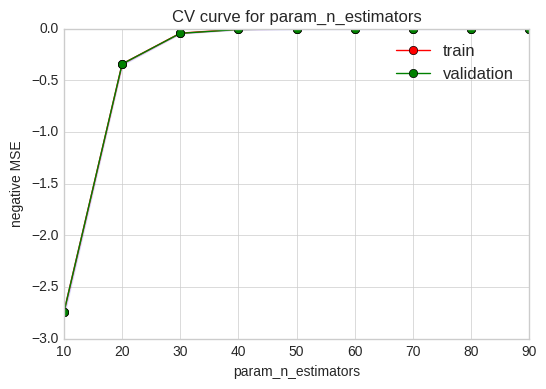

In [69]:
param_grid={'n_estimators': range(10,100,10)
           }
grid_search, results = do_grid_search(estimator = XGBRegressor(seed=0, max_depth=8, learning_rate=0.1), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_n_estimators')

40 Estimators give almost 0 validation error. Will use default 100 estimators though. Less number of estimators has given poor performance o Kaggle

# Max depth

CPU times: user 6.83 s, sys: 104 ms, total: 6.93 s
Wall time: 3min 26s
Test set log adj RMSE: 0.05345
Best parameters: {'max_depth': 3}
Best cross-validation score: -0.00


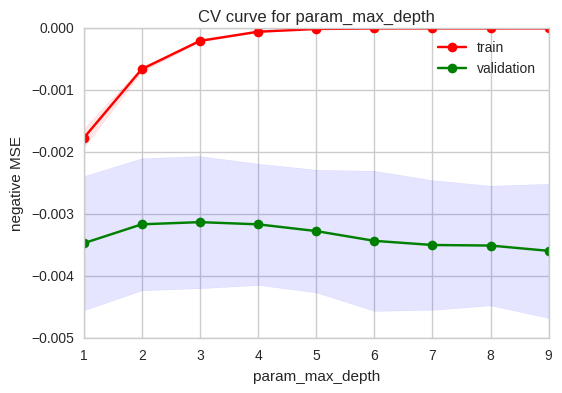

In [139]:
param_grid={'max_depth': range(1,10)
           }
grid_search, results = do_grid_search(estimator = XGBRegressor(seed=0, n_estimators=500), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_max_depth')

# Learning rate

CPU times: user 1 s, sys: 48 ms, total: 1.05 s
Wall time: 15.3 s
Test set log adj RMSE: 0.05558
Best parameters: {'learning_rate': 0.2}
Best cross-validation score: -0.00


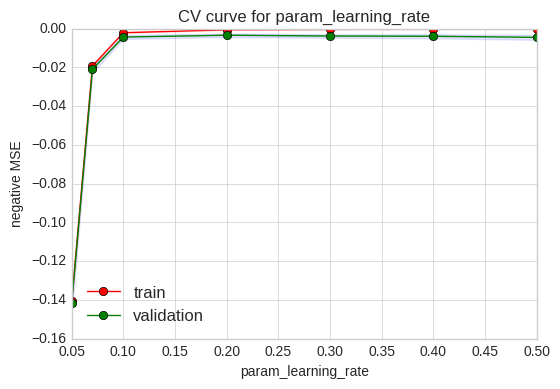

In [73]:
param_grid={'learning_rate': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
           }
grid_search, results = do_grid_search(estimator = XGBRegressor(seed=0, n_estimators=50, max_depth=4), 
                                      param_grid = param_grid)
plot_CV_one_param(results, 'param_learning_rate')

Optimal depth and learning rate seem to be 3 and 0.1 respectively

# With PCA

In [189]:
param_grid={'pca__n_components': [2, 5, 10, 15, 20, 30, 50, 100, 200, 300, 400]
           }
grid_search, results = do_grid_search(estimator = make_pipeline(PCA(), XGBRegressor(seed=0, n_estimators=100, max_depth=4, learning_rate=0.1)), 
                                      param_grid = param_grid)


CPU times: user 1.21 s, sys: 248 ms, total: 1.46 s
Wall time: 54.6 s
Test set log adj RMSE: 0.06540
Best parameters: {'pca__n_components': 20}
Best cross-validation score: -0.00


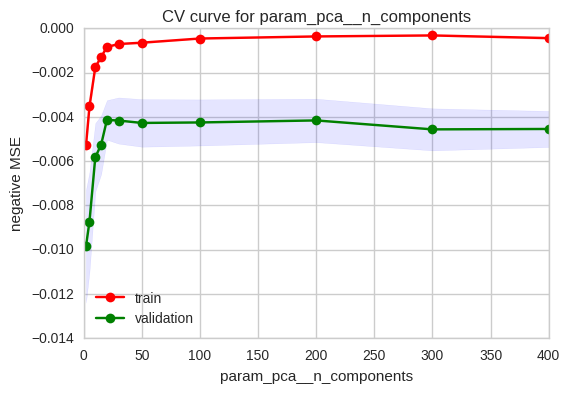

In [190]:
plot_CV_one_param(results, 'param_pca__n_components')

Like RF, PCA with boosting is not a good idea

# Make predictions

In [54]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,1.908485,4.065318,Pave,None,Reg,Lvl,AllPub,...,2.082785,0.0,None,MnPrv,None,0.000000,6,2010,WD,Normal
1,1462,20,RL,1.913814,4.154363,Pave,None,IR1,Lvl,AllPub,...,0.000000,0.0,None,None,Gar2,4.096945,6,2010,WD,Normal
2,1463,60,RL,1.875061,4.140854,Pave,None,IR1,Lvl,AllPub,...,0.000000,0.0,None,MnPrv,None,0.000000,3,2010,WD,Normal
3,1464,60,RL,1.897627,3.999087,Pave,None,IR1,Lvl,AllPub,...,0.000000,0.0,None,None,None,0.000000,6,2010,WD,Normal
4,1465,120,RL,1.643453,3.699491,Pave,None,IR1,HLS,AllPub,...,2.161368,0.0,None,None,None,0.000000,1,2010,WD,Normal


In [55]:
def columns_with_na(df):
    cols = df.columns
    for col in cols:
        if df[col].isnull().sum() > 0:
            print(col, df[col].isnull().sum())

In [56]:
columns_with_na(test)

MSZoning 4
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
KitchenQual 1
Functional 2
SaleType 1


In [57]:
test_dummy.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,1461,20,1.908485,4.065318,5,6,1961,1961,0.000000,468.0,...,0,0,0,1,0,0,0,0,1,0
1461,1462,20,1.913814,4.154363,6,6,1958,1958,2.037426,923.0,...,0,0,0,1,0,0,0,0,1,0
1462,1463,60,1.875061,4.140854,5,5,1997,1998,0.000000,791.0,...,0,0,0,1,0,0,0,0,1,0
1463,1464,60,1.897627,3.999087,6,6,1998,1998,1.322219,602.0,...,0,0,0,1,0,0,0,0,1,0
1464,1465,120,1.643453,3.699491,8,5,1992,1992,0.000000,263.0,...,0,0,0,1,0,0,0,0,1,0


In [58]:
columns_with_na(test_dummy)

# Predict Train Sale Price For All Estimators

Ensemble solution using all models was made by using r$^2$ to find explained variance in held out test set during training, and using this to get proportions of each model's prediction of submission set to contribute to final prediction. 
High r$^2$ means contributing more to final prediction.


In [59]:
from collections import OrderedDict
def predicted_train_saleprice(estimators, sub_X_train, sub_y_train, sub_X_test, sub_y_test, all_X_train, all_y_train):
    '''
    Returns - dataframe of fitted values for each estimator provided
            - percentage importance of each estimator according to test score
    Input: ordered dictionary of (estimator name : estimator) pairs, X, y
    '''
    predicted_values = OrderedDict()
    test_scores = OrderedDict()
    estimator_importances = OrderedDict()
    
    for est_name, estimator in estimators.items():
        estimator.fit(all_X_train, all_y_train) 
        predicted_values[est_name] = estimator.predict(X) # fitted values on all X
        
        estimator.fit(sub_X_train, sub_y_train)
        score = estimator.score(sub_X_test, sub_y_test)
        test_scores[est_name] = score
        print('test score for ', est_name, ' is ', score)
    
    total_test_score = sum(list(test_scores.values()))
    print('total test score is ', total_test_score)
    
    for est_name, test_score in test_scores.items():
        importance = (test_score / total_test_score)
        estimator_importances[est_name] = importance
        print('importance for', est_name, importance)
        
        
    return pd.DataFrame(predicted_values), estimator_importances

# NB: rough work ahead

My submission score using all models has been worse than when using one gradient boosting model.
My best score has come using just one random forest and one gradient boosting model.
Currently around position 1100 / 5500 participants

In [119]:
estimators_no_pca = OrderedDict({'lasso': make_pipeline(StandardScaler(), Lasso(random_state=0, alpha=0.001)), 
                                'ridge': make_pipeline(StandardScaler(), Ridge(random_state=0, alpha=1)), 
                                'elastic_net': make_pipeline(StandardScaler(), ElasticNet(random_state=0, alpha=0.1, l1_ratio=0.01)), 
                                'SVR': make_pipeline(MinMaxScaler(), SVR(gamma=0.001, C=1)), 
                                'kernel_ridge': make_pipeline(MinMaxScaler(), KernelRidge(alpha=0.01, gamma=0.001)), 
                                'random_forest': RandomForestRegressor(random_state=0, max_depth=7, max_features=20, n_jobs=-1), 
                                'gradient_booster': XGBRegressor(seed=0, max_depth=3, n_estimators=50, learning_rate=0.1)})

In [172]:
estimators_no_pca_2 = OrderedDict({'random_forest': RandomForestRegressor(random_state=0, n_estimators=500, max_depth=12, max_features=130, n_jobs=-1),
                                   'gradient_booster': XGBRegressor(seed=0, max_depth=3, n_estimators=500, learning_rate=0.1)})

In [62]:
estimators_with_pca = OrderedDict({'random_forest_pca': make_pipeline(PCA(n_components=20), 
                                                                      RandomForestRegressor(random_state=0, n_estimators=500, max_depth=12, n_jobs=-1)),
                                   'gradient_booster': make_pipeline(PCA(n_components=20), 
                                                                     XGBRegressor(seed=0, max_depth=3, n_estimators=500, learning_rate=0.1))})

In [152]:
fitted_values, estimator_importances = predicted_train_saleprice(estimators_no_pca,
                                                                 X_train, y_train, 
                                                                 X_test, y_test, 
                                                                 X, y)

test score for  SVR  is  0.808242385022
test score for  lasso  is  0.718402345865
test score for  gradient_booster  is  0.843580657707
test score for  ridge  is  0.639831472061
test score for  random_forest  is  0.802551314558
test score for  kernel_ridge  is  0.630120776848
test score for  elastic_net  is  0.762098532664
total test score is  5.20482748473
importance for SVR 0.155287065209
importance for lasso 0.138026158979
importance for gradient_booster 0.162076583745
importance for ridge 0.1229303899
importance for random_forest 0.154193643673
importance for kernel_ridge 0.121064680568
importance for elastic_net 0.146421477926


In [63]:
fitted_values, estimator_importances = predicted_train_saleprice(estimators_with_pca,
                                                                 X_train, y_train, 
                                                                 X_test, y_test, 
                                                                 X, y)

test score for  random_forest_pca  is  0.823190590462
test score for  gradient_booster  is  0.856293992251
total test score is  1.67948458271
importance for random_forest_pca 0.490144773542
importance for gradient_booster 0.509855226458


In [64]:
estimator_importances.values()

odict_values([0.49014477354248992, 0.50985522645751014])

In [65]:
fitted_values.head()

,random_forest_pca,gradient_booster
0,5.307275,5.318655
1,5.255967,5.257055
2,5.351086,5.348400
3,5.140352,5.158720
4,5.403835,5.422094


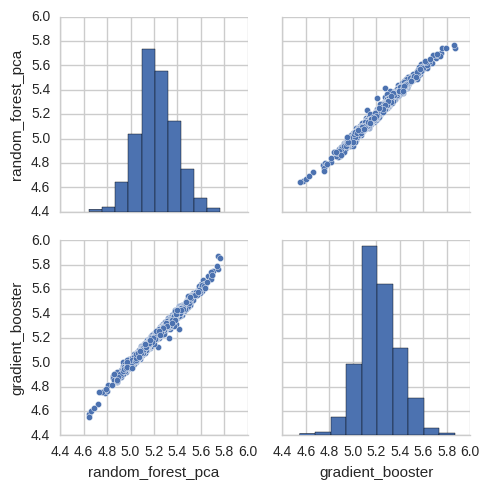

In [66]:
sns.pairplot(fitted_values)

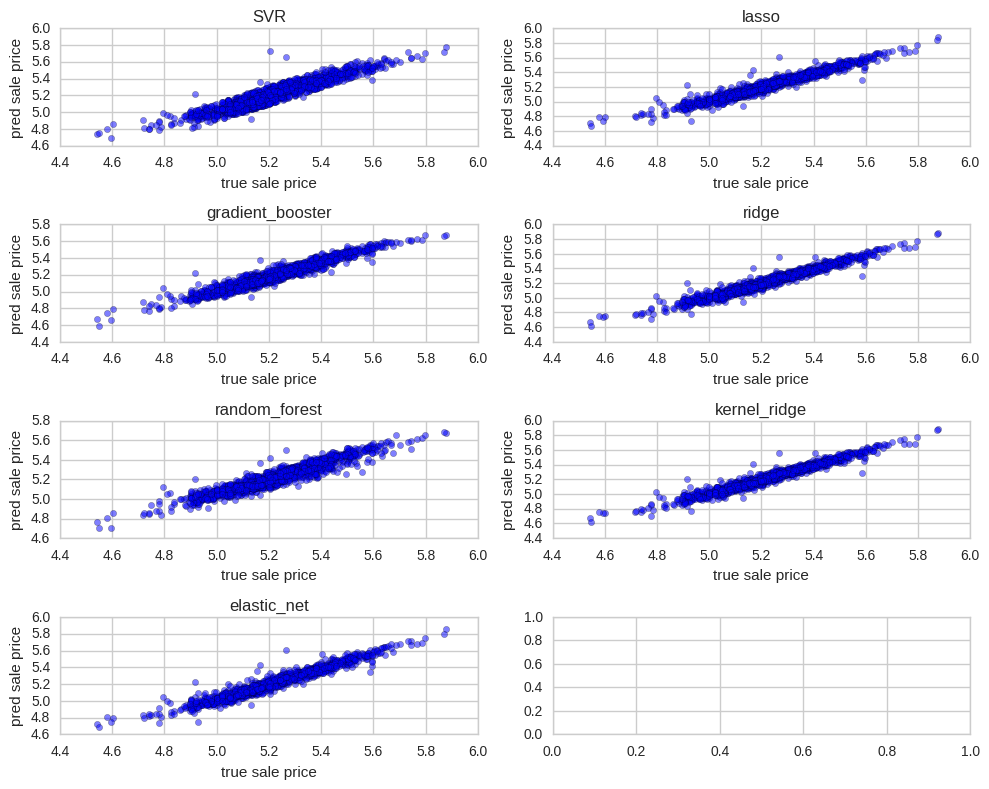

In [86]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))

plot_names = fitted_values.columns

for name, ax in zip(plot_names, axes.ravel()):
    ax.scatter(y, fitted_values[name], alpha=0.5)
    ax.set(xlabel='true sale price', ylabel='pred sale price', title=name)

fig.tight_layout()
plt.show();

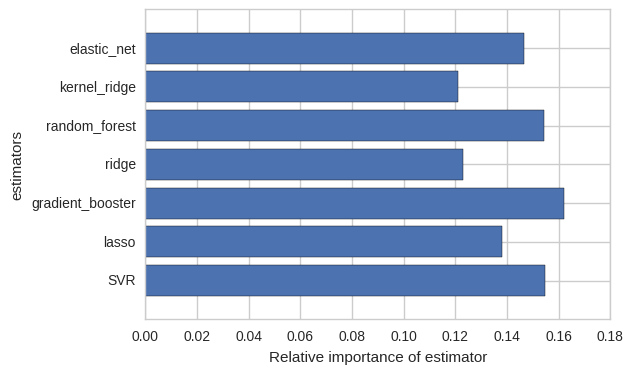

In [87]:
fig, ax = plt.subplots()

ax.barh(range(7), estimator_importances.values(), align='center')
ax.set(xlabel = 'Relative importance of estimator', 
       ylabel = 'estimators', 
       yticklabels = estimator_importances.keys(), 
       yticks = range(7))
plt.show()

# Predict test sale price

In [67]:
def predicted_test_saleprice(estimators, X_train, y_train, X_test):
    '''
    Returns ensemble predicted values all estimators provided
    Input: ordered dictionary of (estimator name : estimator) pairs, X, y
    '''
    predicted_values = OrderedDict()
    ensemble_contribution = OrderedDict()
    
    for est_name, estimator in estimators.items():
        estimator.fit(X_train, y_train)
        predicted_values[est_name] = estimator.predict(X_test)
        ensemble_contribution[est_name] = predicted_values[est_name] * estimator_importances[est_name]
    
    return pd.DataFrame(predicted_values), pd.DataFrame(ensemble_contribution)

In [68]:
predicted_test_sales, ensemble_test_sales = predicted_test_saleprice(estimators_with_pca, X, y, test_dummy)

In [69]:
ensemble_test_sales.head()

,random_forest_pca,gradient_booster
0,2.492463,2.617185
1,2.556957,2.653179
2,2.586209,2.674333
3,2.576506,2.699184
4,2.580376,2.703506


In [70]:
final_predicted_saleprice = ensemble_test_sales.sum(axis=1)

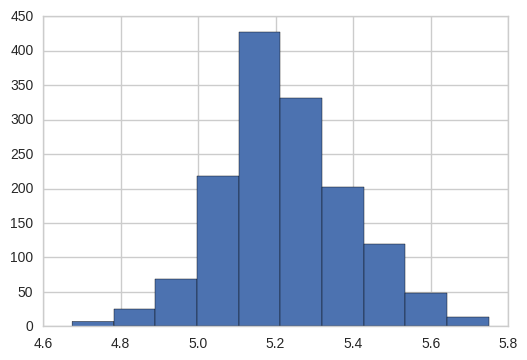

In [71]:
final_predicted_saleprice.hist()

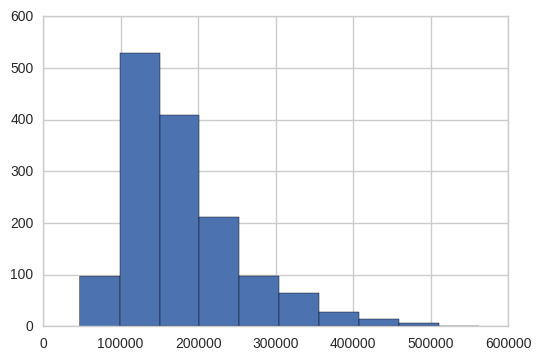

In [72]:
final_predicted_saleprice = final_predicted_saleprice.apply(lambda x: 10**x)
final_predicted_saleprice.hist()

In [73]:
test_dummy.shape, final_predicted_saleprice.shape

((1459, 406), (1459,))

In [74]:
preds = pd.DataFrame({'Id': test.Id, 'SalePrice': final_predicted_saleprice})
preds.to_csv('data/regression_submission.csv', index=False)
print('Saved predictions to data folder')

Saved predictions to data folder
